In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from copy import deepcopy

# SciPy for statistical analysis
from scipy import stats
from scipy.stats import t

# Scikit-learn utilities
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay, classification_report
)

import matplotlib.pyplot as plt

from sklearn.utils import resample, class_weight
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer

# TensorFlow and Keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, Input, Concatenate,
    LayerNormalization, MultiHeadAttention, Add
)
import keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping
# SHAP for explainability
import shap


In [ ]:
def focal_loss(gamma=2., alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * tf.pow(y_pred, gamma) * (1 - y_true)
        loss = weight * cross_entropy
        return tf.reduce_mean(loss)

    return focal_loss_fixed

In [ ]:
# ===========================
# Load and preprocess dataset
# ===========================

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/Shared drives/ABCD_Model/for_JS_final_withgroup.csv'
df = pd.read_csv(file_path)
df['site'] = df['site_id_l.baseline_year_1_arm_1'].str.extract(r'(\d+)$').astype(int)

features_baseline = [ #first time series point
    'interview_age.baseline_year_1_arm_1',
    'KSADSintern.baseline_year_1_arm_1',
    'nihtbx_cryst_agecorrected.baseline_year_1_arm_1',
    'ACEs.baseline_year_1_arm_1',
    'avgPFCthick_QA.baseline_year_1_arm_1',
    'rsfmri_c_ngd_cgc_ngd_cgc_QA.baseline_year_1_arm_1',
    'rsfmri_c_ngd_dt_ngd_dt_QA.baseline_year_1_arm_1'
]

features_followup = [ #second time series points
    'interview_age.2_year_follow_up_y_arm_1',
    'KSADSintern.2_year_follow_up_y_arm_1',
    'nihtbx_cryst_agecorrected.2_year_follow_up_y_arm_1',
    'ACEs.2_year_follow_up_y_arm_1',
    'avgPFCthick_QA.2_year_follow_up_y_arm_1',
    'rsfmri_c_ngd_cgc_ngd_cgc_QA.2_year_follow_up_y_arm_1',
    'rsfmri_c_ngd_dt_ngd_dt_QA.2_year_follow_up_y_arm_1',
]

features_all_time = features_baseline + features_followup

cross_sectional_features = [ #additional features not time series
    'rel_family_id',
    'demo_sex_v2',
    'race_ethnicity',
    'acs_raked_propensity_score',
    'speechdelays',
    'motordelays',
    'fam_history_8_yes_no',
]

for col in features_all_time + cross_sectional_features:
    df[col] = df[col].astype(str).str.strip()
    df.loc[df[col] == '', col] = np.nan
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Step 2: Drop rows with missing values in key column(s)
df.dropna(subset=features_all_time + ['group_PDvLP_3timepoint'], inplace=True)

# Step 3: KNN Imputation on features
#imputer = KNNImputer(n_neighbors=5) #comment these two lines for non data imputation
#df[features_all_time + cross_sectional_features] = imputer.fit_transform(df[features_all_time + cross_sectional_features])

print(f"Total samples after cleaning: {len(df)}")


site_ids = df['site'].unique()
site_metrics = []
all_cross_importances = []
all_long_importances = []
all_predictions = []


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total samples after cleaning: 4153


In [ ]:
# === Define Transformer block ===
def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([inputs, x])

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([res, x])


In [ ]:
#leave one site out cv

for test_site in site_ids:
    print(f"\n==== Testing on site {test_site} ====")

    df_train = df[df['site'] != test_site]
    df_test = df[df['site'] == test_site]


    df_majority = df_train[df_train['group_PDvLP_3timepoint'] == 0]
    df_minority = df_train[df_train['group_PDvLP_3timepoint'] == 1]

    # Upsample minority class to match majority class
    df_minority_oversampled = resample(
        df_minority,
        replace=True,    # sample with replacement
        n_samples=len(df_majority),  # match majority class count
        random_state=42  # reproducible
    )

    # below line implements minority oversampling
    #df_train = pd.concat([df_majority, df_minority_oversampled])


    if df_train.empty or df_test.empty:
        print(f"Skipping site {test_site} due to empty split.")
        continue

    # Time series sequences
    X_train_ts, y_train = [], []
    for _, row in df_train.iterrows():
        baseline = row[features_baseline].values.astype(np.float32)
        followup = row[features_followup].values.astype(np.float32)
        if baseline.shape != followup.shape:
            continue
        seq = np.stack([baseline, followup])
        X_train_ts.append(seq)
        y_train.append(row['group_PDvLP_3timepoint'])

    X_test_ts, y_test = [], []
    for _, row in df_test.iterrows():
        baseline = row[features_baseline].values.astype(np.float32)
        followup = row[features_followup].values.astype(np.float32)
        if baseline.shape != followup.shape:
            continue
        seq = np.stack([baseline, followup])
        X_test_ts.append(seq)
        y_test.append(row['group_PDvLP_3timepoint'])

    X_train_ts = np.array(X_train_ts)
    X_test_ts = np.array(X_test_ts)
    y_train = np.array(y_train).astype(int)
    y_test = np.array(y_test).astype(int)

    if len(X_train_ts) == 0 or len(X_test_ts) == 0:
        print(f"Skipping site {test_site} due to no valid samples.")
        continue

    # Cross-sectional
    X_train_cross = df_train[cross_sectional_features].copy()
    X_test_cross = df_test[cross_sectional_features].copy()

    imputer = KNNImputer(n_neighbors=5) #comment these two lines for non data imputation
    X_train_cross = imputer.fit_transform(X_train_cross)
    X_test_cross = imputer.transform(X_test_cross)


    # ==================
    # Standardize
    # ==================
    scaler_ts = StandardScaler()
    X_train_ts_flat = X_train_ts.reshape(-1, X_train_ts.shape[2])
    X_test_ts_flat = X_test_ts.reshape(-1, X_test_ts.shape[2])

    X_train_ts_scaled = scaler_ts.fit_transform(X_train_ts_flat).reshape(X_train_ts.shape)
    X_test_ts_scaled = scaler_ts.transform(X_test_ts_flat).reshape(X_test_ts.shape)

    scaler_cross = StandardScaler()
    X_train_cross_scaled = scaler_cross.fit_transform(X_train_cross)
    X_test_cross_scaled = scaler_cross.transform(X_test_cross)

    # ================
    # Build Transformer + Cross-Sectional model
    # ================


    input_ts = Input(shape=(X_train_ts_scaled.shape[1], X_train_ts_scaled.shape[2]), name='time_series_input')
    x = transformer_encoder(input_ts)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', name='ts_dense1')(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    ts_output = x[:, -1, :]  # Take last time step

    input_cross = Input(shape=(X_train_cross_scaled.shape[1],), name='cross_sectional_input')
    concatenated = Concatenate()([ts_output, input_cross])
    dense1 = Dense(32, activation='relu', name='combined_dense1')(concatenated)
    output = Dense(1, activation='sigmoid')(dense1)

    model = Model(inputs=[input_ts, input_cross], outputs=output)

    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])


    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    class_weights_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = dict(zip(np.unique(y_train), class_weights_array))


    model.fit(
        [X_train_ts_scaled, X_train_cross_scaled], y_train,
        epochs=20,
        batch_size=16,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0
        #class_weight=class_weights
    )

    y_pred_probs = model.predict([X_test_ts_scaled, X_test_cross_scaled]).flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)

    if np.isnan(y_pred_probs).any():
        print("NaNs detected in prediction probabilities, skipping AUC calculation for this site.")
        auc = float('nan')
    elif len(np.unique(y_test)) == 2:
        auc = roc_auc_score(y_test, y_pred_probs)
    else:
        auc = float('nan')

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)


    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        print(f"Confusion matrix is not 2x2 for site {test_site}. It is:\n{cm}")
        tn = fp = fn = tp = 0

    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print(f"AUC:       {auc:.3f}")
    print(f"Negative Predictive Value (NPV): {npv:.2f}")
    print(f"Specificity: {specificity:.3f}")



    # ======================
    # Feature Importance
    # ======================



    X_ts_for_shap = X_test_ts_scaled[:100]  # or all: X_test_ts_scaled
    X_cross_for_shap = X_test_cross_scaled[:100]
    explainer = shap.GradientExplainer(model, [X_ts_for_shap, X_cross_for_shap])

    # Compute SHAP values for test longitudinal data (along with cross-sectional)
    shap_values = explainer.shap_values([X_test_ts_scaled, X_test_cross_scaled])
    shap_long = shap_values[0]  # shape: (samples, 2, 7)
    shap_cross = shap_values[1]  # SHAP values for cross-sectional input (shape: samples x features)



    # Average absolute SHAP values over samples and time steps for each longitudinal feature
    mean_abs_shap_long = np.mean(np.abs(shap_long), axis=(0,1))  # shape: (7,)
    mean_abs_shap_cross = np.mean(np.abs(shap_cross), axis=0)  # Average over samples


    # Store for averaging later across sites
    all_long_importances.append(mean_abs_shap_long)
    site_metrics.append((test_site, acc, prec,rec,npv,auc,specificity,f1))
    all_cross_importances.append(mean_abs_shap_cross)


    df_test_results = df_test[['src_subject_id']].copy()
    df_test_results['true_label'] = y_test
    df_test_results['predicted_label'] = y_pred
    df_test_results['predicted_prob'] = y_pred_probs
    df_test_results['site'] = test_site
    all_predictions.append(df_test_results)





==== Testing on site 21 ====
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Accuracy:  0.954
Precision: 0.833
Recall:    0.357
F1 Score:  0.500
AUC:       0.813
Negative Predictive Value (NPV): 0.96
Specificity: 0.995

==== Testing on site 11 ====
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Accuracy:  0.986
Precision: 1.000
Recall:    0.333
F1 Score:  0.500
AUC:       1.000
Negative Predictive Value (NPV): 0.99
Specificity: 1.000

==== Testing on site 4 ====
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Accuracy:  0.915
Precision: 0.188
Recall:    0.214
F1 Score:  0.200
AUC:       0.620
Negative Predictive Value (NPV): 0.96
Specificity: 0.951

==== Testing on site 5 ====
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Accuracy:  0.958
Precision: 0.000
Recall:    0.000
F1 Score:  0.000
AUC:       0.790
Negative Predictive Value (NPV): 0.96
Specificity: 1.000

==== Testing on site 6 ====
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Accuracy:  0.973
Precision: 0.375
Recall:    0.600
F1 Score:  0.462
AUC:       0.730
Negative P

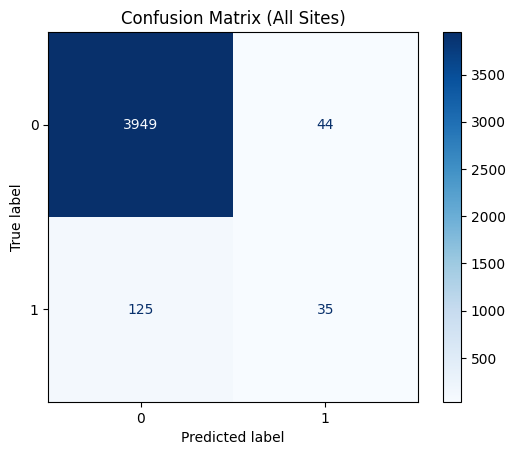

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3993
           1       0.44      0.22      0.29       160

    accuracy                           0.96      4153
   macro avg       0.71      0.60      0.64      4153
weighted avg       0.95      0.96      0.95      4153


===== Final Report =====
Site 21: Accuracy = 0.954, Precision = 0.833, Recall = 0.357, NPV = 0.958, AUC = 0.813, Specificity = 0.995, F1 = 0.500
Site 11: Accuracy = 0.986, Precision = 1.000, Recall = 0.333, NPV = 0.986, AUC = 1.000, Specificity = 1.000, F1 = 0.500
Site 4: Accuracy = 0.915, Precision = 0.188, Recall = 0.214, NPV = 0.958, AUC = 0.620, Specificity = 0.951, F1 = 0.200
Site 5: Accuracy = 0.958, Precision = 0.000, Recall = 0.000, NPV = 0.958, AUC = 0.790, Specificity = 1.000, F1 = 0.000
Site 6: Accuracy = 0.973, Precision = 0.375, Recall = 0.600, NPV = 0.992, AUC = 0.730, Specificity = 0.980, F1 = 0.462
Site 20: Accuracy = 0.929, Precision = 0.600, Reca

In [ ]:

all_predictions_df = pd.concat(all_predictions, ignore_index=True)

save_path = '/content/drive/Shared drives/ABCD_Model/transformer/Transformer_all_subject_predictions.csv'
all_predictions_df.to_csv(save_path, index=False)


# Get the true and predicted labels from your aggregated DataFrame
y_true = all_predictions_df['true_label']
y_pred = all_predictions_df['predicted_label']

# Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (All Sites)')
plt.show()

# Optional: classification report
print(classification_report(y_true, y_pred))

# =======================
# Final Report
# =======================


def mean_ci(data, confidence=0.95):
    a = np.array(data)
    n = len(a)
    mean = np.mean(a)
    sem = stats.sem(a)
    h = sem * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, mean - h, mean + h

def mean_ci_long(data, confidence=0.95):
    data = np.array(data)
    n = len(data)
    mean = np.mean(data).item()  # .item() converts 0-d array to float
    sem = np.std(data, ddof=1) / np.sqrt(n)
    h = sem * t.ppf((1 + confidence) / 2., n-1)
    lower = (mean - h).item()
    upper = (mean + h).item()
    return mean, lower, upper

print("\n===== Final Report =====")
for site, acc, prec, rec, npv, auc, spec, f1 in site_metrics:
    print(f"Site {site}: Accuracy = {acc:.3f}, Precision = {prec:.3f}, Recall = {rec:.3f}, NPV = {npv:.3f}, AUC = {auc:.3f}, Specificity = {spec:.3f}, F1 = {f1:.3f}")

# Proper unpacking (8 elements per tuple)
acc_list = [acc for _, acc, _, _, _, _, _, _ in site_metrics]
prec_list = [prec for _, _, prec, _, _, _, _, _ in site_metrics]
rec_list = [rec for _, _, _, rec, _, _, _, _ in site_metrics]
npv_list = [npv for _, _, _, _, npv, _, _, _ in site_metrics]
auc_list = [auc for _, _, _, _, _, auc, _, _ in site_metrics if not np.isnan(auc)]
spec_list = [spec for _, _, _, _, _, _, spec, _ in site_metrics]
f1_list = [f1 for _, _, _, _, _, _, _, f1 in site_metrics]

avg_acc, acc_lower, acc_upper = mean_ci(acc_list)
avg_prec, prec_lower, prec_upper = mean_ci(prec_list)
avg_rec, rec_lower, rec_upper = mean_ci(rec_list)
avg_npv, npv_lower, npv_upper = mean_ci(npv_list)
avg_auc, auc_lower, auc_upper = mean_ci(auc_list)
avg_spec, spec_lower, spec_upper = mean_ci(spec_list)
avg_f1, f1_lower, f1_upper = mean_ci(f1_list)

print("\n===== LOSO Summary (Average ± 95% CI) =====")
print(f"Accuracy:                {avg_acc:.3f} [{acc_lower:.3f}, {acc_upper:.3f}]")
print(f"Precision (PPV):         {avg_prec:.3f} [{prec_lower:.3f}, {prec_upper:.3f}]")
print(f"Recall (Sensitivity):    {avg_rec:.3f} [{rec_lower:.3f}, {rec_upper:.3f}]")
print(f"NPV:                     {avg_npv:.3f} [{npv_lower:.3f}, {npv_upper:.3f}]")
print(f"AUC:                     {avg_auc:.3f} [{auc_lower:.3f}, {auc_upper:.3f}]")
print(f"Specificity:             {avg_spec:.3f} [{spec_lower:.3f}, {spec_upper:.3f}]")
print(f"F1 Score:                {avg_f1:.3f} [{f1_lower:.3f}, {f1_upper:.3f}]")




all_cross_importances = np.array(all_cross_importances)  # shape: (n_folds, n_cross_features)

print("\n=== Average Cross-Sectional Feature Importances (SHAP) ===")
for i, feat in enumerate(cross_sectional_features):  # cross-sectional feature names
    mean, lower, upper = mean_ci_long(all_cross_importances[:, i])
    print(f"{feat}: {mean:.4f} (95% CI: [{lower:.4f}, {upper:.4f}])")


all_long_importances = np.array(all_long_importances)  # shape: (n_folds, n_features)

print("\n=== Average Longitudinal Feature Importances (SHAP) ===")
for i, feat in enumerate(features_baseline):  # use your longitudinal feature names
    mean, lower, upper = mean_ci_long(all_long_importances[:, i])
    print(f"{feat}: {mean:.4f} (95% CI: [{lower:.4f}, {upper:.4f}])")



In [ ]:
report_path = '/content/drive/Shared drives/ABCD_Model/transformer/Transformer_final_report.txt'

with open(report_path, 'w') as f:
    def write(s):
        print(s)
        f.write(s + '\n')

    write("\n===== Final Report =====")
    for site, acc, prec, rec, npv, auc, spec, f1 in site_metrics:
        write(f"Site {site}: Accuracy = {acc:.3f}, Precision = {prec:.3f}, Recall = {rec:.3f}, NPV = {npv:.3f}, AUC = {auc:.3f}, Specificity = {spec:.3f}, F1 = {f1:.3f}")

    acc_list = [acc for _, acc, _, _, _, _, _, _ in site_metrics]
    prec_list = [prec for _, _, prec, _, _, _, _, _ in site_metrics]
    rec_list = [rec for _, _, _, rec, _, _, _, _ in site_metrics]
    npv_list = [npv for _, _, _, _, npv, _, _, _ in site_metrics]
    auc_list = [auc for _, _, _, _, _, auc, _, _ in site_metrics if not np.isnan(auc)]
    spec_list = [spec for _, _, _, _, _, _, spec, _ in site_metrics]
    f1_list = [f1 for _, _, _, _, _, _, _, f1 in site_metrics]

    avg_acc, acc_lower, acc_upper = mean_ci(acc_list)
    avg_prec, prec_lower, prec_upper = mean_ci(prec_list)
    avg_rec, rec_lower, rec_upper = mean_ci(rec_list)
    avg_npv, npv_lower, npv_upper = mean_ci(npv_list)
    avg_auc, auc_lower, auc_upper = mean_ci(auc_list)
    avg_spec, spec_lower, spec_upper = mean_ci(spec_list)
    avg_f1, f1_lower, f1_upper = mean_ci(f1_list)

    write("\n===== LOSO Summary (Average ± 95% CI) =====")
    write(f"Accuracy:                {avg_acc:.3f} [{acc_lower:.3f}, {acc_upper:.3f}]")
    write(f"Precision (PPV):         {avg_prec:.3f} [{prec_lower:.3f}, {prec_upper:.3f}]")
    write(f"Recall (Sensitivity):    {avg_rec:.3f} [{rec_lower:.3f}, {rec_upper:.3f}]")
    write(f"NPV:                     {avg_npv:.3f} [{npv_lower:.3f}, {npv_upper:.3f}]")
    write(f"AUC:                     {avg_auc:.3f} [{auc_lower:.3f}, {auc_upper:.3f}]")
    write(f"Specificity:             {avg_spec:.3f} [{spec_lower:.3f}, {spec_upper:.3f}]")
    write(f"F1 Score:                {avg_f1:.3f} [{f1_lower:.3f}, {f1_upper:.3f}]")

    all_cross_importances = np.array(all_cross_importances)
    write("\n=== Average Cross-Sectional Feature Importances (SHAP) ===")
    for i, feat in enumerate(cross_sectional_features):
        mean, lower, upper = mean_ci_long(all_cross_importances[:, i])
        write(f"{feat}: {mean:.4f} (95% CI: [{lower:.4f}, {upper:.4f}])")

    all_long_importances = np.array(all_long_importances)
    write("\n=== Average Longitudinal Feature Importances (SHAP) ===")
    for i, feat in enumerate(features_baseline):
        mean, lower, upper = mean_ci_long(all_long_importances[:, i])
        write(f"{feat}: {mean:.4f} (95% CI: [{lower:.4f}, {upper:.4f}])")



===== Final Report =====
Site 21: Accuracy = 0.954, Precision = 0.833, Recall = 0.357, NPV = 0.958, AUC = 0.813, Specificity = 0.995, F1 = 0.500
Site 11: Accuracy = 0.986, Precision = 1.000, Recall = 0.333, NPV = 0.986, AUC = 1.000, Specificity = 1.000, F1 = 0.500
Site 4: Accuracy = 0.915, Precision = 0.188, Recall = 0.214, NPV = 0.958, AUC = 0.620, Specificity = 0.951, F1 = 0.200
Site 5: Accuracy = 0.958, Precision = 0.000, Recall = 0.000, NPV = 0.958, AUC = 0.790, Specificity = 1.000, F1 = 0.000
Site 6: Accuracy = 0.973, Precision = 0.375, Recall = 0.600, NPV = 0.992, AUC = 0.730, Specificity = 0.980, F1 = 0.462
Site 20: Accuracy = 0.929, Precision = 0.600, Recall = 0.231, NPV = 0.939, AUC = 0.783, Specificity = 0.987, F1 = 0.333
Site 1: Accuracy = 0.961, Precision = 1.000, Recall = 0.333, NPV = 0.960, AUC = 0.785, Specificity = 1.000, F1 = 0.500
Site 18: Accuracy = 0.973, Precision = 1.000, Recall = 0.500, NPV = 0.973, AUC = 0.936, Specificity = 1.000, F1 = 0.667
Site 3: Accuracy =

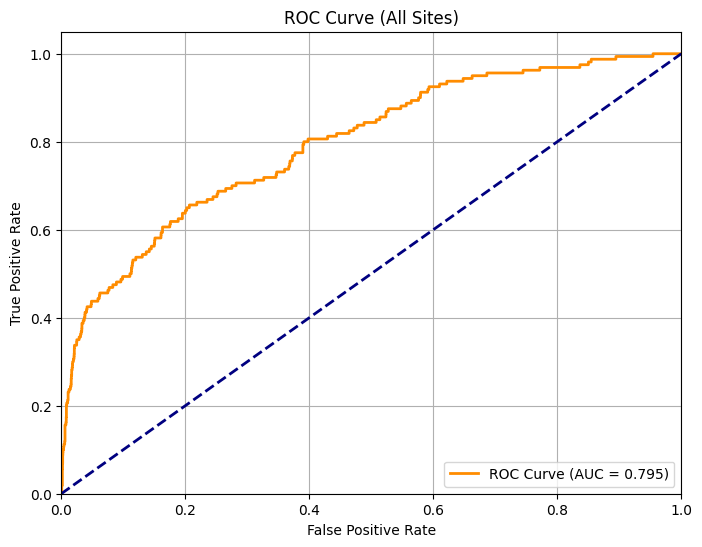

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Extract values
y_true = all_predictions_df['true_label']
y_score = all_predictions_df['predicted_prob']

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (All Sites)')
plt.legend(loc='lower right')
plt.grid(True)

# Save the figure
save_path = '/content/drive/Shared drives/ABCD_Model/transformer/Transformer_roc_curve_all_sites.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
